In [14]:
from sklearn import datasets
import numpy as np
import pandas as pd
import heapq
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### داده ها خوانده میشود و داخل dataframe ریخته میشود.

In [46]:
mnist = datasets.load_digits()
mod_mnist = np.array(mnist.data)
mod_mnist = mod_mnist.T
pd_mnist = pd.DataFrame(mnist.data)
pd_mnist['actual'] = mnist.target

### در این تابع داده ها به دو بخش آموزش و تست با نسبت 20 و 80 تقسیم میشوند

In [42]:
def train_test_split(data):
    m = len(data)
    train = data.iloc[0:int(0.8*m), :]
    test = data.iloc[int(0.8*m): , :]
    return train, test

### در این بخش one vs all پیاده سازی شده که به ازای هر label یک مدل logistic regression به صورت one vs all برای آن label خروجی داده میشود.

In [79]:
def one_vs_all(X, Y, one_label):
    modified_Y = np.reshape(np.array([1*int(y==one_label) for y in Y ]), (1, len(Y)))
    clf = LogisticRegression(random_state=0).fit(X, modified_Y.T)
    return clf
    

In [57]:
shuffle_data = pd_mnist.sample(frac=1).reset_index(drop=True)
train, test = train_dev_test_split(shuffle_data)
X_train, Y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [86]:
import warnings
warnings.filterwarnings('ignore')
models = {}
possible_classes = list(dict.fromkeys(mnist.target))
print(possible_classes)
for cur_class in possible_classes:
    models[cur_class] = one_vs_all(X_train, Y_train, cur_class)
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [100]:
print(models[2].predict_proba([np.array(range(64))]))

[[5.53779245e-13 1.00000000e+00]]


### در این بخش بیشترین احتمال برای هر مدل one vs all پیدا میشود و label متناظر با آن به عنوان خروجی داده میشود. 

In [104]:
def predict(X):
    prob = {}
    max_prob, best_class = 0, 0
    for cur_class in possible_classes:
        temp_prob = models[cur_class].predict_proba(X)[0][1]
        if temp_prob > max_prob:
            max_prob = temp_prob
            best_class = cur_class
    return best_class

### داده تست و داده آموزشی گرفته میشود و  ماتریس پریشانی و دقت به عنوان خروجی با استفاده از تابع های قبلی برگردانده میشود. 

In [121]:
def main_function(X, Y, show_data, print_flag = True):
    curr_data = X.copy()
    m_data = len(curr_data)
    correct = 0
    total_predictions = []
    ind = 0
    for index, raw_row in curr_data.iterrows():
        row = raw_row.to_numpy()
        predicted = predict([row])
        if predicted == Y[ind]:
            correct += 1
        total_predictions.append(predicted)
        ind += 1
    error = (m_data - correct)/m_data
    if print_flag:
        print(str(show_data) + str(error))
        print(confusion_matrix(Y, total_predictions, labels=range(len(possible_classes))))
    return total_predictions

In [122]:
main_function(X_train, Y_train.to_numpy(), "training data error: ")
main_function(X_test, Y_test.to_numpy(), "test data error: ")
;

training data error: 0.0055671537926235215
[[143   0   0   0   0   0   0   0   0   0]
 [  0 147   0   1   0   0   0   0   2   0]
 [  0   0 137   0   0   0   0   0   0   0]
 [  0   0   0 149   0   0   0   0   0   0]
 [  0   0   0   0 141   0   0   0   0   0]
 [  0   0   0   0   0 141   0   0   0   0]
 [  0   0   0   0   0   0 140   0   0   0]
 [  0   0   0   0   0   0   0 147   0   0]
 [  0   3   0   0   0   0   0   0 138   0]
 [  0   0   0   1   0   0   0   0   1 146]]
test data error: 0.03888888888888889
[[34  0  0  0  0  1  0  0  0  0]
 [ 0 28  0  0  0  0  2  0  2  0]
 [ 0  1 39  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  0  0  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  0  0 41  0  0  0  0]
 [ 0  0  0  0  0  0 41  0  0  0]
 [ 0  0  0  0  0  0  0 32  0  0]
 [ 0  4  0  1  0  0  0  0 27  1]
 [ 0  0  0  0  0  1  0  0  1 30]]


''

### مقادیر پیش بینی شده و مقادیر واقعی را میگیرد و شکل آن را ترسیم میکند

In [126]:
def show_graph(raw_pixels, y_org, y_pred):
    fig, axis = plt.subplots(5, 5)
    column_counter = 0
    for i in range(len(raw_pixels)):
        row = raw_pixels[i, :-1]
        pixels = row.reshape(8, 8)
        column_counter = column_counter % 5
        axis[int(i/5), column_counter].imshow(pixels, cmap='gray')
        axis[int(i/5), column_counter].set_title('y_org:'+ str(y_org[i])+ ', y_pred:' + str(int(y_pred[i])) )
        column_counter += 1
        fig.set_size_inches(22.5, 15.5)
    plt.subplots_adjust(left=0.2, bottom=0.03, right=0.9, top=0.9, wspace=0.5,
                    hspace=0.85)
    plt.show()

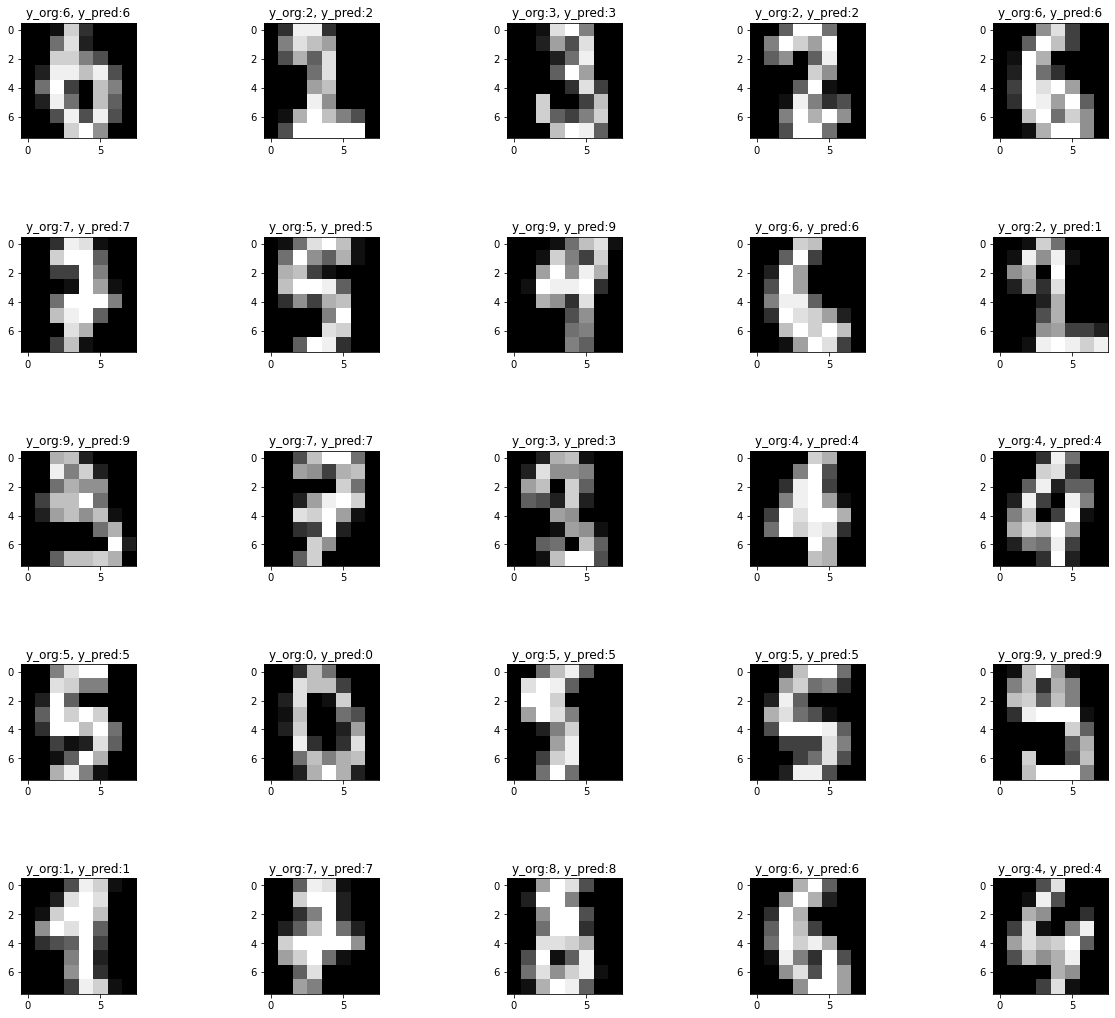

In [128]:
test_sample = test.iloc[0:25, :]
X_sample = X_test.iloc[0:25, :]
Y_sample = Y_test.iloc[0:25]
sample_predictions = main_function(X_sample, Y_sample.to_numpy(), "", False)
show_graph(test_sample.to_numpy(), Y_sample.to_numpy(), sample_predictions)

# ج
### روش k نزدیکترین همسایه هم خطای آموزش و هم خطای تست کمتری از این روش داشت.
### خطای آموزش و تست به ترتیب در k نزدیکترین همسایه برابر با 0.0039 و 0.027 بود ولی در این روش به ترتیب 0.05 و 0.038 است.
### پس روش k نزدیکترین همسایه از روش logistic regression (با این پیاده سازی) روی دیتاست mnist بهتر عمل میکند

# د
### یکی از مشکلاتی که میتواند پیش بیاید در این مشکل نا متوازن شدن است. برای مثال اگر تعداد کلاس ها 5 تا باشد و داده ها بصورت متوازن نیست پخش شده باشند. هر classifier با نسبت داده 80 به 20 مواجه میشود. پس اگر تعداد کلاس ها از این تعداد بیشتر شود یا داده ها نامتوازن شوند به این ترتیب دسته بند های one-vs-all با کلاس های نامتوازن روبرو خواهند شد. برای حل این مشکل میتوان از روش one-vs-one  استفاده کرد که هر دوتایی را با هم مقایسه میکند و دیگر به این مشکل نمیخوریم اگر خود داده های اولیه نامتوازن نباشند.